Importar Librerias


In [2]:
import sys
sys.path.append('./utils')
import pandas as pd
import numpy as np
import dataframe_gen as dg
import graficadores as gfr
import filtros as flt
import ext_coeficientes

import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


Datasets a usar 


In [3]:
ravdess = "./input/ravdess/"
crema = "./input/crema/"
tess = "./input/tess/"

Debido a las diferencias en el formato entregado para cada uno de nuestros datasets debemos generar un dataframe por separado para cada uno de los datasets que queremos usar, aunque nuestro objetivo sea entrenar nuestro modelo con los 3 a la vez

Dataframes

In [4]:
df = pd.concat([dg.ravdess_df(ravdess), dg.crema_df(crema), dg.tess_df(tess)], axis=0)
df.to_csv("data.csv", index=False)

muestra = dg.df_muestra(df)
ruta = np.array(df.Ruta)[1]
data, sample_rate = librosa.load(ruta)

In [5]:
# grafica la forma de onda para cada uno de los elementos de la muestra
def graficar_muestra(muestra):
    for emocion, ruta in zip(muestra.Emociones, muestra.Ruta):
        y, sr = librosa.load(ruta, duration=3)
        gfr.grafica(y, sr, emocion)

# graficar_muestra(muestra)

In [6]:
if os.path.exists('coeficientes.csv'):
    Coeficientes = pd.read_csv('coeficientes.csv')
else:
    X, Y = [], []
    for ruta, Emocion in zip(df.Ruta, df.Emociones):
        feature = ext_coeficientes.get_features(ruta)
        for ele in feature:
            X.append(ele)
            Y.append(Emocion)
    Coeficientes = pd.DataFrame(X)
    Coeficientes['etiquetas'] = Y
    Coeficientes.to_csv('coeficientes.csv', index=False)

Coeficientes.head()


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,etiquetas
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116493e-06,8.190282e-06,0.000007,0.000005,4.245834e-07,neutral
1,0.338732,0.801519,0.848153,0.825450,0.823191,0.838989,0.750829,0.682001,0.722003,0.760672,...,1.568375e-04,1.611375e-04,1.551203e-04,1.419271e-04,1.465343e-04,1.507912e-04,0.000146,0.000143,1.405629e-04,neutral
2,0.188256,0.622125,0.699215,0.753343,0.721212,0.701727,0.682356,0.662828,0.686486,0.733960,...,8.579052e-07,9.576654e-07,7.733596e-07,5.233101e-07,3.592860e-07,9.261693e-07,0.000002,0.000001,7.753986e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984504e-06,7.034949e-06,6.654923e-06,6.979548e-06,1.214236e-05,9.640184e-06,0.000011,0.000006,4.254087e-07,neutral
4,0.323495,0.777478,0.829493,0.810992,0.788253,0.792568,0.746141,0.653097,0.697748,0.745031,...,1.039848e-04,1.021024e-04,1.092291e-04,1.095416e-04,1.053739e-04,1.088844e-04,0.000113,0.000106,9.672472e-05,neutral


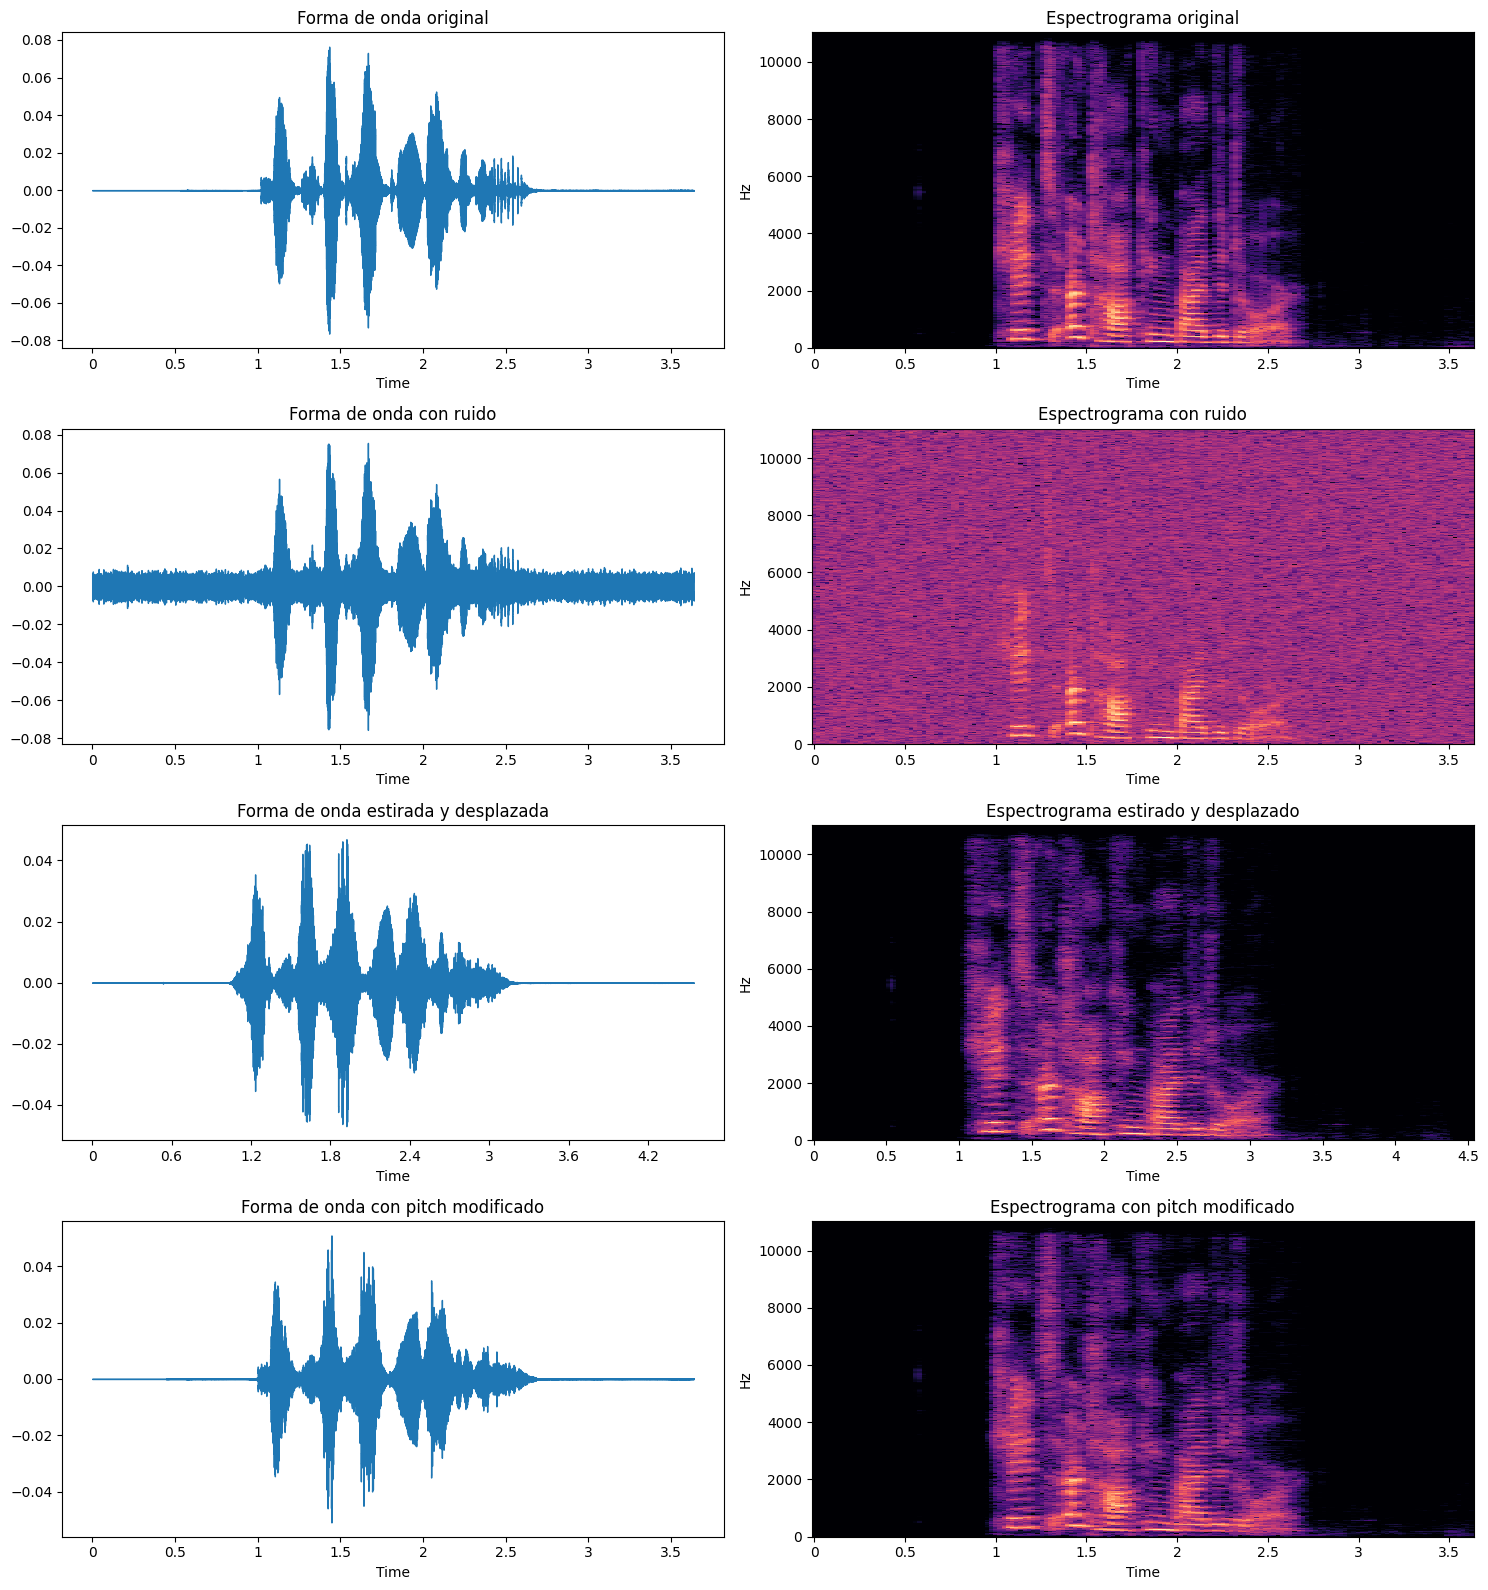


Audio Original:



Audio con Ruido:



Audio Estirado y Desplazado:



Audio con Pitch Modificado:


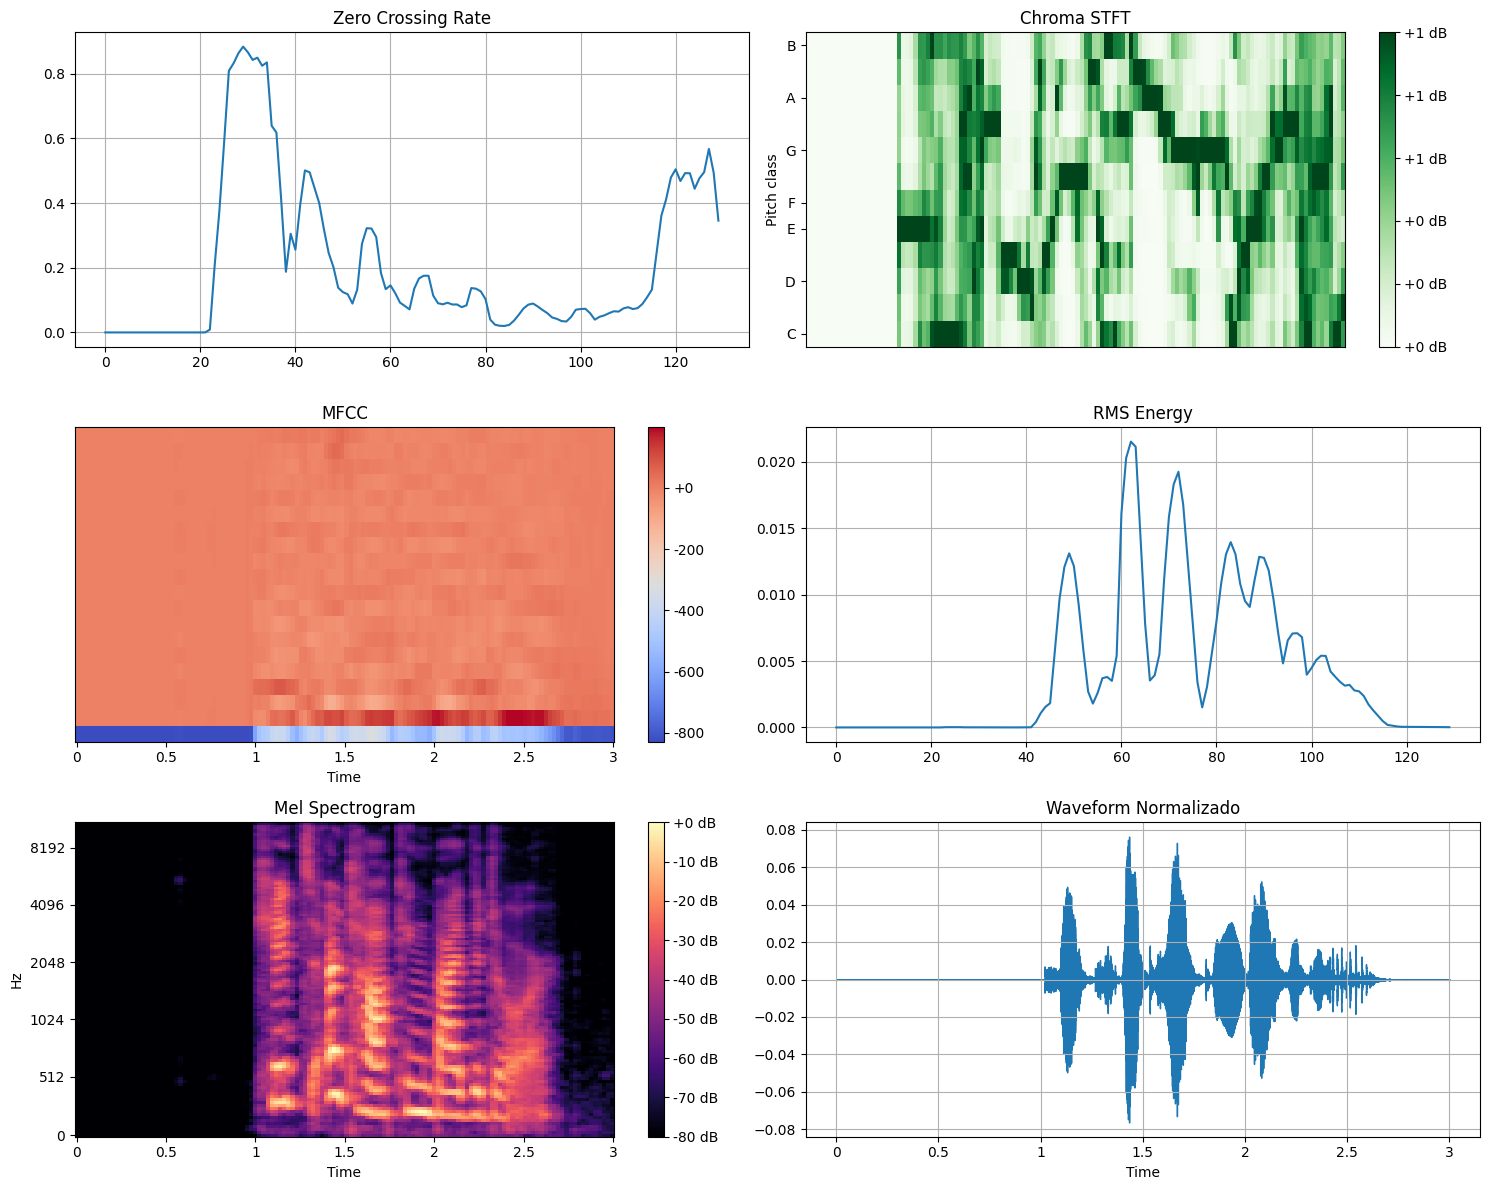

In [7]:

# Ejemplo de uso
audio_path = "./input/ravdess/Actor_02/03-01-01-01-01-01-02.wav"  # Ajusta la ruta según tu estructura
gfr.compare_augmentations(audio_path)
gfr.mostrar_coef(audio_path)


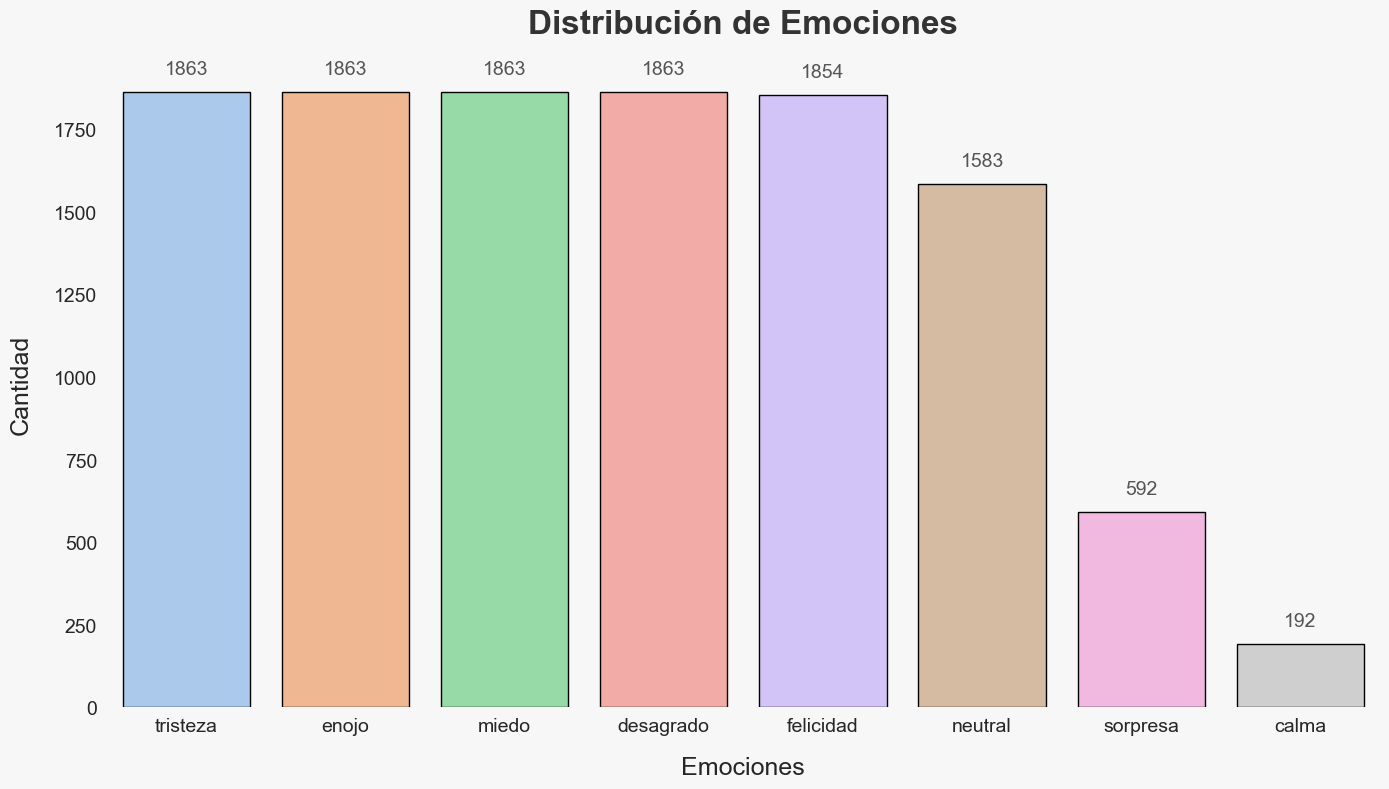

In [8]:
gfr.total_emociones(df)

Proceso de entrenamiento del modelo

In [9]:
X = Coeficientes.iloc[:, :-1].values
Y = Coeficientes['etiquetas'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# hay que transformar nuestros datos para hacer el algoritmo.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

# Guardar el modelo
model.save('modelo_entrenado.h5')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.2595 - loss: 1.8137 - val_accuracy: 0.4174 - val_loss: 1.4431 - learning_rate: 0.0010
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.4087 - loss: 1.4566 - val_accuracy: 0.4716 - val_loss: 1.3065 - learning_rate: 0.0010
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.4629 - loss: 1.3272 - val_accuracy: 0.4870 - val_loss: 1.2537 - learning_rate: 0.0010
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.4790 - loss: 1.2896 - val_accuracy: 0.5156 - val_loss: 1.2160 - learning_rate: 0.0010
Epoch 5/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.4963 - loss: 1.2496 - val_accuracy: 0.5243 - val_loss: 1.1979 - learning_rate: 0.0010
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.5120 - loss: 1.2009 - val_accuracy: 0.5441 - val_loss: 1.1521 - learning_rate: 0.0010
Epoch 7/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.5287 - l

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6186 - loss: 1.0970
Precisión final del modelo: 61.47%


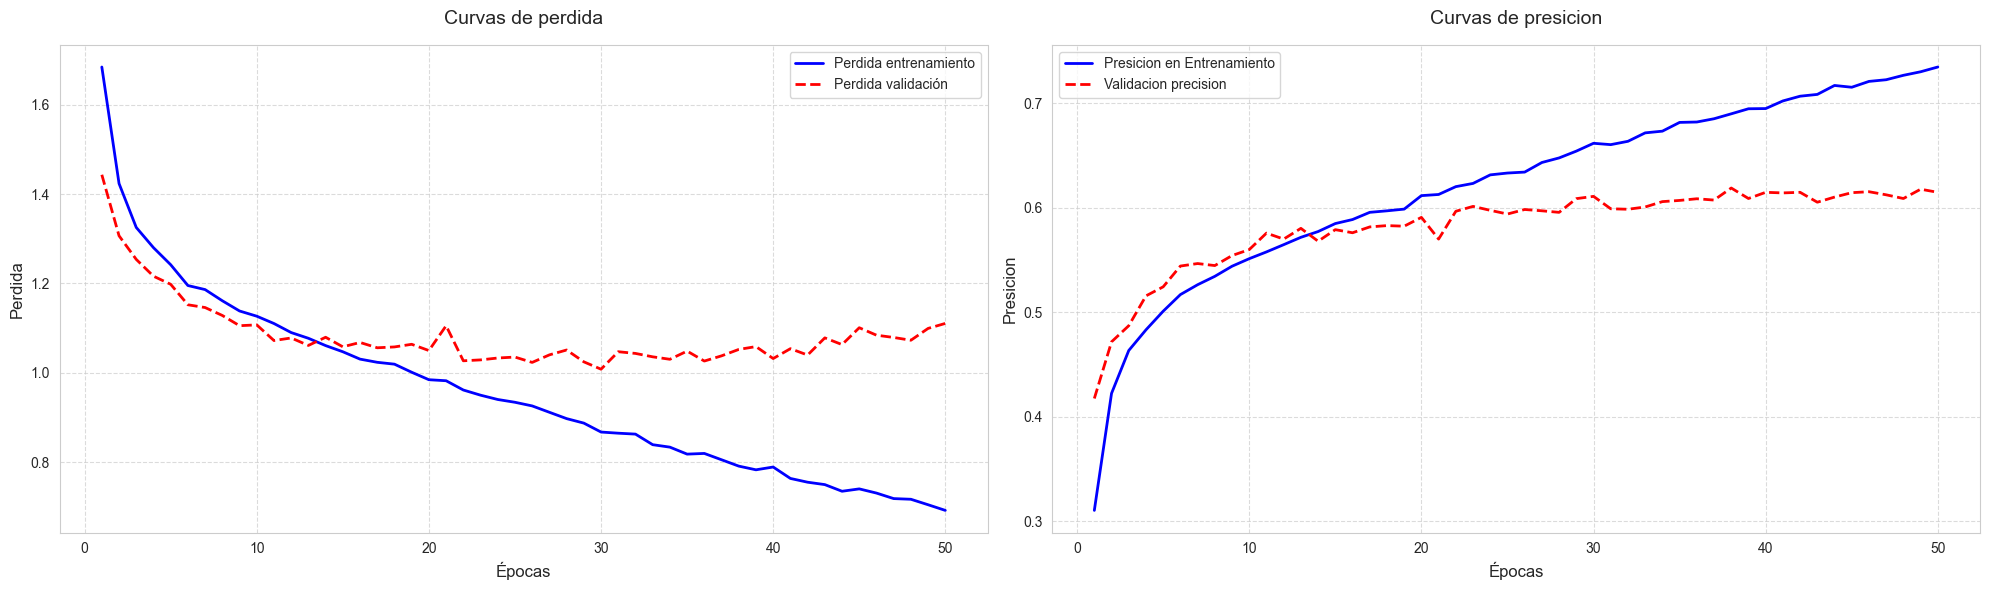

In [10]:
def plot_training_history(history, model, x_test, y_test):
    """Visualiza métricas del entrenamiento del modelo"""
    # Evaluar precisión final
    test_accuracy = model.evaluate(x_test, y_test)[1] * 100
    print(f"Precisión final del modelo: {test_accuracy:.2f}%")
    
    # Preparar datos
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Gráfico de Loss
    ax1.plot(epochs, train_loss, 'b-', label='Perdida entrenamiento', linewidth=2)
    ax1.plot(epochs, val_loss, 'r--', label='Perdida validación', linewidth=2)
    ax1.set_title('Curvas de perdida', fontsize=14, pad=15)
    ax1.set_xlabel('Épocas', fontsize=12)
    ax1.set_ylabel('Perdida', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10)
    
    # Gráfico de Accuracy
    ax2.plot(epochs, train_acc, 'b-', label='Presicion en Entrenamiento', linewidth=2)
    ax2.plot(epochs, val_acc, 'r--', label='Validacion precision', linewidth=2)
    ax2.set_title('Curvas de presicion', fontsize=14, pad=15)
    ax2.set_xlabel('Épocas', fontsize=12)
    ax2.set_ylabel('Presicion', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, model, x_test, y_test)

In [11]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(np.eye(pred_test.shape[1])[np.argmax(pred_test, axis=1)])

y_test_labels = encoder.inverse_transform(y_test)

df_Comparaciones = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_Comparaciones['Predicted Labels'] = y_pred.flatten()
df_Comparaciones['Actual Labels'] = y_test_labels.flatten()

df_Comparaciones.head(10)

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,Predicted Labels,Actual Labels
0,neutral,neutral
1,tristeza,tristeza
2,miedo,miedo
3,tristeza,tristeza
4,sorpresa,sorpresa
5,desagrado,desagrado
6,felicidad,enojo
7,neutral,neutral
8,desagrado,enojo
9,tristeza,neutral


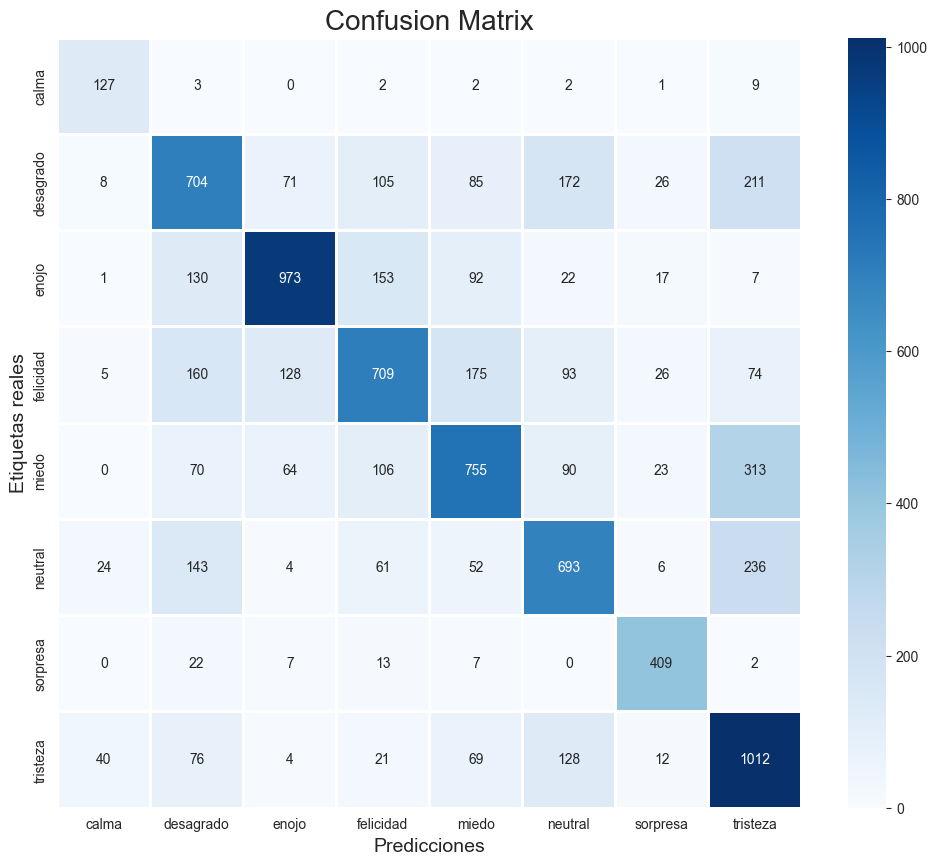

              precision    recall  f1-score   support

       calma       0.62      0.87      0.72       146
   desagrado       0.54      0.51      0.52      1382
       enojo       0.78      0.70      0.74      1395
   felicidad       0.61      0.52      0.56      1370
       miedo       0.61      0.53      0.57      1421
     neutral       0.58      0.57      0.57      1219
    sorpresa       0.79      0.89      0.83       460
    tristeza       0.54      0.74      0.63      1362

    accuracy                           0.61      8755
   macro avg       0.63      0.67      0.64      8755
weighted avg       0.62      0.61      0.61      8755



In [12]:
# Convert y_test from one-hot encoded format to label format
y_test_labels = encoder.inverse_transform(y_test)

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_[0]] , columns = [i for i in encoder.categories_[0]])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicciones', size=14)
plt.ylabel('Etiquetas reales', size=14)
plt.show()

# Convert y_test from one-hot encoded format to label format
y_test_labels = encoder.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred))



Analizando categoría: League Of Legends

Analizando categoría: Valorant

Porcentajes de emociones por categoría:
                   enojo  felicidad  miedo  neutral  tristeza
League Of Legends  61.90       9.52  14.29     4.76      9.52
Valorant           52.94       5.88  23.53     5.88     11.76


<Figure size 1500x800 with 0 Axes>

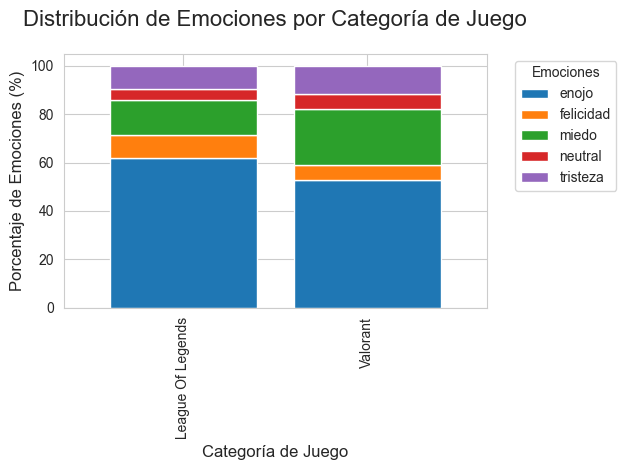

In [13]:
import os
import librosa 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ext_coeficientes as ext
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def analizar_segmento_audio(data, sr, modelo, scaler, encoder):
    """Analiza un segmento de audio y retorna la emoción predicha"""
    features = ext.extract_features(data, sr)
    features = scaler.transform(features.reshape(1, -1))
    features = np.expand_dims(features, axis=2)
    prediccion = modelo.predict(features, verbose=0)
    emocion = encoder.inverse_transform(np.eye(prediccion.shape[1])[np.argmax(prediccion, axis=1)])
    return emocion[0][0]

def analizar_audio_videojuego(audio_path, modelo, scaler, encoder, segment_duration=2.5):
    """Analiza un archivo de audio por segmentos y retorna porcentajes de emociones"""
    data, sr = librosa.load(audio_path)
    
    # Analizar por segmentos
    emociones = []
    for i in range(0, len(data), int(segment_duration * sr)):
        segment = data[i:i + int(segment_duration * sr)]
        if len(segment) >= sr: # Solo analizar segmentos completos
            emocion = analizar_segmento_audio(segment, sr, modelo, scaler, encoder)
            emociones.append(emocion)
    
    # Calcular porcentajes
    if emociones:
        conteo = pd.Series(emociones).value_counts()
        porcentajes = conteo / len(emociones) * 100
        return porcentajes.to_dict()
    return {}

def visualizar_emociones_por_categoria(resultados_df):
    """Crea un gráfico de barras apiladas con los porcentajes de emociones por categoría"""
    plt.figure(figsize=(15, 8))
    
    # Preparar datos para visualización
    df_plot = resultados_df.copy()
    df_plot = df_plot.fillna(0)
    
    # Crear gráfico de barras apiladas
    ax = df_plot.plot(kind='bar', stacked=True, width=0.8)
    
    plt.title('Distribución de Emociones por Categoría de Juego', pad=20, size=16)
    plt.xlabel('Categoría de Juego', size=12)
    plt.ylabel('Porcentaje de Emociones (%)', size=12)
    plt.legend(title='Emociones', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def analizar_videojuegos(directorio_base, modelo, scaler, encoder):
    resultados = {}
    
    for categoria in os.listdir(directorio_base):
        ruta_categoria = os.path.join(directorio_base, categoria)
        if os.path.isdir(ruta_categoria):
            print(f"\nAnalizando categoría: {categoria}")
            
            emociones_categoria = []
            for archivo in os.listdir(ruta_categoria):
                if archivo.endswith(('.wav', '.mp3')):
                    ruta_completa = os.path.join(ruta_categoria, archivo)
                    try:
                        porcentajes = analizar_audio_videojuego(ruta_completa, modelo, scaler, encoder)
                        emociones_categoria.append(porcentajes)
                    except Exception as e:
                        print(f"Error procesando {archivo}: {str(e)}")
            
            # Promediar porcentajes para la categoría
            if emociones_categoria:
                df_categoria = pd.DataFrame(emociones_categoria).fillna(0)
                resultados[categoria] = df_categoria.mean()
    
    return pd.DataFrame(resultados).T

if __name__ == "__main__":
    # Cargar modelo y preparar encoder/scaler
    modelo = load_model("modelo_entrenado.h5")
    encoder = OneHotEncoder()
    scaler = StandardScaler()
    
    # Cargar y ajustar con datos de entrenamiento
    datos_entrenamiento = pd.read_csv("coeficientes.csv")
    X = datos_entrenamiento.iloc[:, :-1].values
    Y = datos_entrenamiento['etiquetas'].values.reshape(-1, 1)
    scaler.fit(X)
    encoder.fit(Y)
    
    # Analizar audios
    directorio_videojuegos = "./input/juegos/"
    resultados_df = analizar_videojuegos(directorio_videojuegos, modelo, scaler, encoder)
    
    if not resultados_df.empty:
        print("\nPorcentajes de emociones por categoría:")
        print(resultados_df.round(2))
        visualizar_emociones_por_categoria(resultados_df)
    else:
        print("\nNo se encontraron resultados.")